In [387]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.optimize import fsolve

See: https://www.sympy.org/scipy-2017-codegen-tutorial/notebooks/32-chemical-kinetics-symbolic-construction.html

Definición del mecanismo

In [388]:
reactions1 = [
    # (coeff, r_stoich, net_stoich)
    ('k1', {'[NO]': 1, '[RSH]': 1}, {'[NO]': -1, '[RSH]': -1, '[X]': 1}),
    ('k2', {'[NO]': 1, '[HNO]': 1}, {'[NO]': -1, '[HNO]': -1, '[P]': 1}),
    ('k3', {'[HNO]': 1, '[RSH]': 1}, {'[HNO]': -1, '[RSH]': -1, '[P]': 1}),
    ('k4', {'[HNO]': 2}, {'[HNO]': -2, '[P]': 1}),
    ('k5', {'[X]': 1}, {'[X]': -1, '[HNO]': 1}),
    ('k6', {'[X]': 1, '[RSH]': 1}, {'[X]': -1, '[RSH]': -1,  '[P]': 1})
]
names = '[NO] [RSH] [HNO] [X] [P]'.split()

In [389]:
from operator import mul
from functools import reduce
import sympy as sym

def prod(seq):
    return reduce(mul, seq) if seq else 1

def mk_exprs_symbs(rxns, names):
    # create symbols for reactants
    symbs = sym.symbols(names, real=True, nonnegative=True)
    # map between reactant symbols and keys in r_stoich, net_stoich
    c = dict(zip(names, symbs))
    f = {n: 0 for n in names}
    k = []
    for coeff, r_stoich, net_stoich in rxns:
        k.append(sym.S(coeff))
        r = k[-1]*prod([c[rk]**p for rk, p in r_stoich.items()])  # EXERCISE: c[rk]**p
        for net_key, net_mult in net_stoich.items():
            f[net_key] += net_mult*r  # EXERCISE: net_mult*r
    return [f[n] for n in names], symbs, tuple(k)

Definición del sistema de ecuaciones diferenciales

In [390]:
sym.init_printing()
ydot, y, k = mk_exprs_symbs(reactions, names)
ydot

definición de f a integrar

In [391]:
t = sym.symbols('t')  # not used in this case.
f = sym.lambdify((y, t) + k, ydot, 'numpy')
#f = sym.lambdify((t, y) + k, ydot)
#f([10e6,10e6,0,0,0],0,1000,5.6e6,3e6,8e6,0.01,1e5)
f

<function _lambdifygenerated(_Dummy_243, t, k1, k2, k3, k4, k5, k6)>

In [393]:
tout = np.linspace(0, 200, num = 2001)
t_span = np.array([tout[0], tout[-1]])
k_vals = (1e-3, 5.6, 3, 8, 0.01, 0.1)
y0 = [10, 2, 0, 0, 0]
yout, info = odeint(f, y0, tout, k_vals, full_output=True)
#yout, info = solve_ivp(f, t_span , y0, args = k_vals)

Para mejorar la integracion numerica, para todo a uM

k1 = 1000 M-1 s-1 --> 1000 M -1 s-1 * 1e-6 M /1uM --> 1e-3 uMs-1

k2 = 5e6 M-1 s-1 --> 5.6 uMs-1

k3 = 3e6 M-1 s-1 --> 3 uMs-1

k4 = 8e6 M-1 s-1 --> 8.6 uMs-1

k5 = 0.01 s-1

k6 = 1e5 M-1 s-1 -->  0.1 uMs-1

The Jacobian was evaluated 21 times.


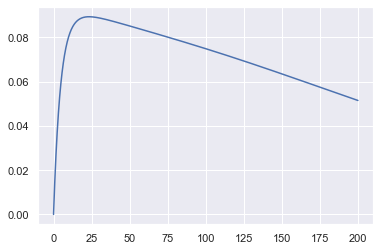

In [394]:
plt.plot(tout, yout[:,3])
#plt.legend(names)
print("The Jacobian was evaluated %d times." % info['nje'][-1])

Calculo el jacobiano para acelerar la integracion

In [395]:
J = sym.Matrix(ydot).jacobian(y)  # EXERCISE: jacobian
J_cb = sym.lambdify((y, t) + k, J, 'numpy')  # EXERCISE: (y, t) + k

In [396]:
yout, info = odeint(f, y0, tout, k_vals, full_output=True, Dfun=J_cb)


The Jacobian was evaluated 23 times.


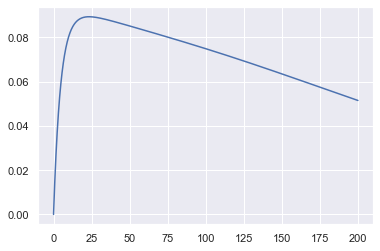

In [397]:
plt.plot(tout, yout[:,3])
#plt.legend(names)
print("The Jacobian was evaluated %d times." % info['nje'][-1])

In [398]:
%timeit odeint(f, y0, tout, k_vals)

3.99 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [399]:
%timeit odeint(f, y0, tout, k_vals, Dfun=J_cb)

3.71 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Evaluamos el efecto de las contantes desconocidas (k1, k5, k6)

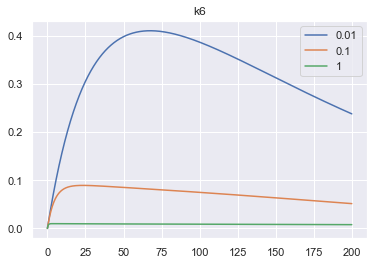

In [400]:
tout = np.linspace(0, 200, num = 2001)
t_span = np.array([tout[0], tout[-1]])
y0 = [10, 2, 0, 0, 0]
k_test = [0.01, 0.1, 1]
for k in k_test:
    k_vals = (1e-3, 5.6, 3, 8, 0.01, k)

    yout, info = odeint(f, y0, tout, k_vals, full_output=True, Dfun=J_cb)
    plt.plot(tout, yout[:,3])
plt.legend(k_test)
plt.title('k6');

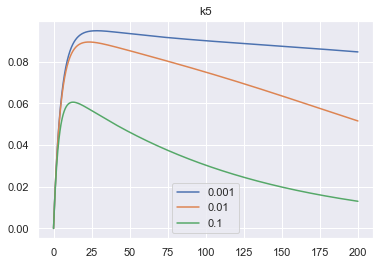

In [401]:
tout = np.linspace(0, 200, num = 2001)
t_span = np.array([tout[0], tout[-1]])
y0 = [10, 2, 0, 0, 0]
k_test = [0.001, 0.01, 0.1]
for k in k_test:
    k_vals = (1e-3, 5.6, 3, 8, k, 0.1)

    yout, info = odeint(f, y0, tout, k_vals, full_output=True, Dfun=J_cb)
    plt.plot(tout, yout[:,3])
plt.legend(k_test)
plt.title('k5');

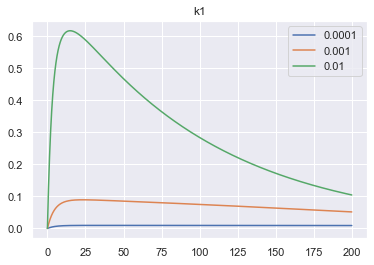

In [402]:
tout = np.linspace(0, 200, num = 2001)
t_span = np.array([tout[0], tout[-1]])
y0 = [10, 2, 0, 0, 0]
k_test = [1e-4, 1e-3, 1e-2]
for k in k_test:
    k_vals = (k, 5.6, 3, 8, 0.01, 0.1)

    yout, info = odeint(f, y0, tout, k_vals, full_output=True, Dfun=J_cb)
    plt.plot(tout, yout[:,3])
plt.legend(k_test)
plt.title('k1');

Reobtencion de las constantes por ajuste no lineal

In [412]:
tout = np.linspace(0, 200, num = 2001)
t_span = np.array([tout[0], tout[-1]])
y0 = [10, 2, 0, 0, 0]
k_vals = (0.04, 5.6, 3, 8, 0.01, 0.0)
yout, info = odeint(f, y0, tout, k_vals, full_output=True, Dfun=J_cb)

In [413]:
y_hno_noise = yout[:,3] + 0.001*np.random.normal(0,1, yout[:,3].shape)

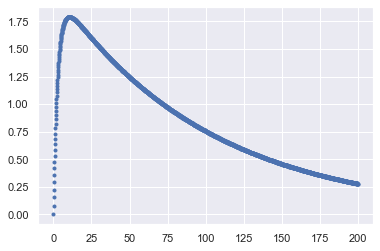

In [414]:
plt.plot(tout, y_hno_noise,'.')
plt.show()

# Ajuste de ecuaciones diferenciales

In [415]:
from scipy.optimize import curve_fit

Construyo una función que remplaza los parámetros conocidos que se van a fijar

In [416]:
def replace_fix_and_free(func, fixed_list):
    to_replace = [(ki, fixed_list[ki]) for ki in fixed_list.keys()]
    for i in range(len(func)):
        func[i] = func[i].subs(to_replace)
    return func

In [487]:
#Construyo el sistema de ecuaciones
ydot, y, k = mk_exprs_symbs(reactions, names)

#Reemplazo las constantes que considero fijas:
fixed_list = {'k2': 5.6, 'k4': 8} # En uM-1 s-1
ydot = replace_fix_and_free(ydot, fixed_list)

#Creo la funcion a evaluar, removiendo las constantes que son fijas
k_free = tuple([ki for ki in k if ki not in [sym.Symbol(kj) for kj in fixed_list.keys()]])

t = sym.symbols('t')  # not used in this case.
f = sym.lambdify((y, t) + k_free, ydot, 'numpy')

#Calculo el jacobiano
J = sym.Matrix(ydot).jacobian(y)  # EXERCISE: jacobian
J_cb = sym.lambdify((y, t) + k_free, J, 'numpy')  # EXERCISE: (y, t) + k


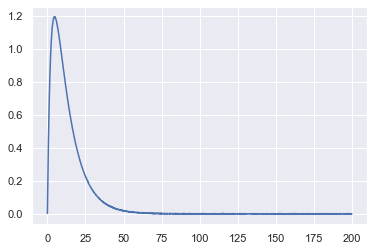

In [489]:
def hno_t(tspan, k1, k3, k5, k6):
    k_vals = (k1, k3, k5, k6)
    y0 = [10, 2, 0, 0, 0]
    yout = odeint(f, y0, tspan, k_vals, Dfun=J_cb)
    return yout[:,3]

tspan = np.linspace(0, 200, num = 2001)
k_vals = (0.04, 3, 1e-1, 1e-5)
hno_data = hno_t(tspan, *k_vals)

y_hno_noise = hno_data + 0.001*np.random.normal(0,1, len(hno_data))
plt.plot(tspan, y_hno_noise);

In [494]:
popt, _ = curve_fit(hno_t, tspan, y_hno_noise, p0 = [0.04, 3, 1e-2, 1e-5], bounds = (0, np.inf))
popt

array([0.04145879, 2.9716773 , 0.09553604, 0.00964015])

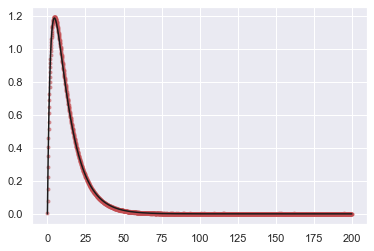

In [495]:
plt.plot(tspan, y_hno_noise,'r.', alpha = 0.5)
plt.plot(tspan, hno_t(tspan, *popt),'k')
plt.show()

# Analisis de experimentos

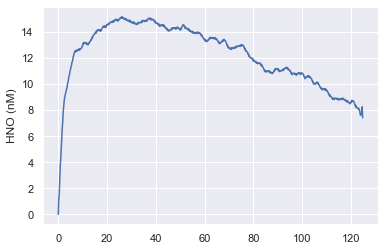

In [514]:
df = pd.read_csv('/Users/dbikiel/Dropbox/Compartidas/Compartida Dami - Seba/Obtencion Cte NO-tiol/Trazas Cys-NO/Cys_3uM_NO_10uM.csv', header = None)
df.columns = ['tiempo', 'HNO']
plt.plot(df.tiempo, df.HNO)
plt.ylabel('HNO (nM)');

In [515]:
def hno_t(tspan, k1, k3, k5, k6):
    k_vals = (k1,k3, k5, k6)
    y0 = [10, 2, 0, 0, 0]
    yout = odeint(f, y0, tspan, k_vals, Dfun=J_cb)
    return yout[:,3]

npoints = -1

popt, _ = curve_fit(hno_t, df[:npoints].tiempo, df[:npoints].HNO/1000, p0 = [0.04, 3, 5e-2, 7e-1], bounds = (0, np.inf))
popt

array([0.00332683, 1.54893115, 0.01036662, 2.20551908])

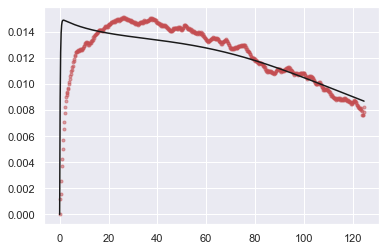

In [516]:
plt.plot(df[:npoints].tiempo, df[:npoints].HNO/1000,'r.', alpha = 0.5)
plt.plot(df[:npoints].tiempo, hno_t(df[:npoints].tiempo, *popt),'k')
plt.show()

## mecanismo 2

In [517]:
reactions2 = [
    # (coeff, r_stoich, net_stoich)
    ('k1', {'[NO]': 1, '[RSH]': 1}, {'[NO]': -1, '[RSH]': -1, '[X]': 1}),
    ('k2', {'[NO]': 1, '[HNO]': 1}, {'[NO]': -1, '[HNO]': -1, '[P]': 1}),
    ('k3', {'[HNO]': 1, '[RSH]': 1}, {'[HNO]': -1, '[RSH]': -1, '[P]': 1}),
    ('k4', {'[HNO]': 2}, {'[HNO]': -2, '[P]': 1}),
    ('k5', {'[X]': 2}, {'[X]': -2, '[P]': 1}),
    ('k6', {'[X]': 1, '[NO]': 1}, {'[X]': -1, '[NO]': -1,  '[HNO]': 1})
]
names = '[NO] [RSH] [HNO] [X] [P]'.split()

In [524]:
#Construyo el sistema de ecuaciones
ydot2, y2, k_2 = mk_exprs_symbs(reactions2, names)

#Reemplazo las constantes que considero fijas:
fixed_list = {'k2': 5.6, 'k3': 3, 'k4': 8} # En uM-1 s-1
ydot2 = replace_fix_and_free(ydot2, fixed_list)

#Creo la funcion a evaluar, removiendo las constantes que son fijas
k_2_free = tuple([ki for ki in k_2 if ki not in [sym.Symbol(kj) for kj in fixed_list.keys()]])

t = sym.symbols('t')  # not used in this case.
f2 = sym.lambdify((y2, t) + k_2_free, ydot2, 'numpy')

#Calculo el jacobiano
J2 = sym.Matrix(ydot2).jacobian(y2)  # EXERCISE: jacobian
J2_cb = sym.lambdify((y2, t) + k_2_free, J2, 'numpy')  # EXERCISE: (y, t) + k


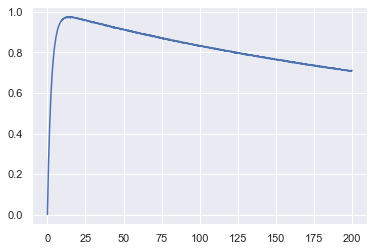

In [525]:
def hno_t_2(tspan, k1, k5, k6):
    k_vals = (k1, k5, k6)
    y0 = [10, 1, 0, 0, 0]
    yout = odeint(f2, y0, tspan, k_vals, Dfun=J2_cb)
    return yout[:,3]

tspan = np.linspace(0, 200, num = 2001)
k_vals = (4e-2, 1e-3, 1e-5)
hno_data = hno_t_2(tspan, *k_vals)

y_hno_noise = hno_data + 0.001*np.random.normal(0,1, len(hno_data))
plt.plot(tspan, y_hno_noise);

### Ajuste de datos a mecanismo 2

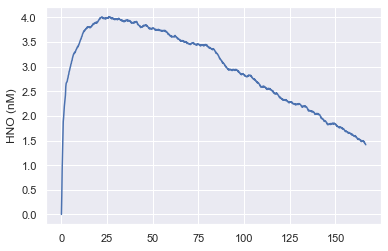

In [561]:
df = pd.read_csv('/Users/dbikiel/Dropbox/Compartidas/Compartida Dami - Seba/Obtencion Cte NO-tiol/Trazas Cys-NO/Cys_1uM_NO_10uM.csv', header = None)
df.columns = ['tiempo', 'HNO']
plt.plot(df.tiempo, df.HNO)
plt.ylabel('HNO (nM)');

In [568]:
def hno_t_2(tspan, k1, k5, k6):
    k_vals = (k1, k5, k6)
    y0 = [10, 1, 0, 0, 0]
    yout = odeint(f2, y0, tspan, k_vals, Dfun=J2_cb)
    return yout[:,3]

npoints = 200

popt, _ = curve_fit(hno_t_2, df[:npoints].tiempo, df[:npoints].HNO/1000, p0 = [0.04,1e-10,0], bounds = (0, np.inf))
popt

array([1.25875718e-04, 5.20005163e-06, 3.14458343e-02])

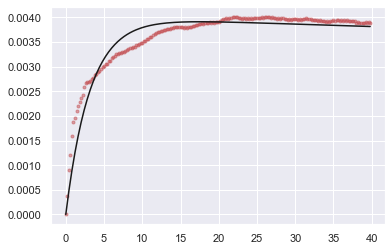

In [569]:
plt.plot(df[:npoints].tiempo, df[:npoints].HNO/1000,'r.', alpha = 0.5)
plt.plot(df[:npoints].tiempo, hno_t_2(df[:npoints].tiempo, *popt),'k')
plt.show()

In [386]:
print(ydot[3])

[NO]*[RSH]*k1 - [RSH]*[X]*k6 - [X]*k5


# Mecanismo 3: incluye ambos mecanismos

In [571]:
reactions3 = [
    # (coeff, r_stoich, net_stoich)
    ('k1', {'[NO]': 1, '[RSH]': 1}, {'[NO]': -1, '[RSH]': -1, '[X]': 1}),
    ('k2', {'[NO]': 1, '[HNO]': 1}, {'[NO]': -1, '[HNO]': -1, '[P]': 1}),
    ('k3', {'[HNO]': 1, '[RSH]': 1}, {'[HNO]': -1, '[RSH]': -1, '[P]': 1}),
    ('k4', {'[HNO]': 2}, {'[HNO]': -2, '[P]': 1}),
    
    ('k5', {'[X]': 1}, {'[X]': -1, '[HNO]': 1}),
    ('k6', {'[X]': 1, '[RSH]': 1}, {'[X]': -1, '[RSH]': -1,  '[P]': 1}),
    ('k7', {'[X]': 2}, {'[X]': -2,  '[P]': 1}),    
    ('k8', {'[X]': 1, '[NO]': 1}, {'[X]': -1, '[NO]': -1,  '[HNO]': 1})
]
names = '[NO] [RSH] [HNO] [X] [P]'.split()

In [573]:
ydot3, y3, k_3 = mk_exprs_symbs(reactions3, names)
ydot3

In [579]:
#Reemplazo las constantes que considero fijas:
fixed_list = {'k2': 5.6, 'k3': 3, 'k4': 8} # En uM-1 s-1
ydot3 = replace_fix_and_free(ydot3, fixed_list)

#Creo la funcion a evaluar, removiendo las constantes que son fijas
k_3_free = tuple([ki for ki in k_3 if ki not in [sym.Symbol(kj) for kj in fixed_list.keys()]])

t = sym.symbols('t')  # not used in this case.
f3 = sym.lambdify((y3, t) + k_3_free, ydot3, 'numpy')

#Calculo el jacobiano
J3 = sym.Matrix(ydot3).jacobian(y3)  # EXERCISE: jacobian
J3_cb = sym.lambdify((y3, t) + k_3_free, J3, 'numpy')  # EXERCISE: (y, t) + k

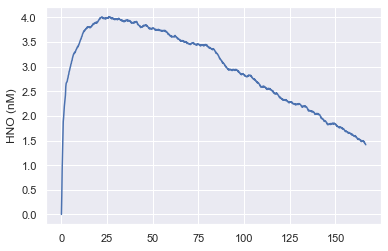

In [598]:
df = pd.read_csv('/Users/dbikiel/Dropbox/Compartidas/Compartida Dami - Seba/Obtencion Cte NO-tiol/Trazas Cys-NO/Cys_1uM_NO_10uM.csv', header = None)
df.columns = ['tiempo', 'HNO']
plt.plot(df.tiempo, df.HNO)
plt.ylabel('HNO (nM)');

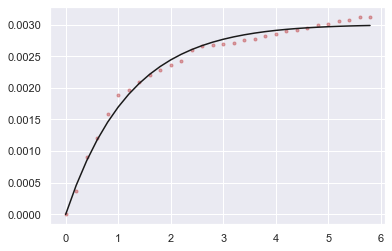

array([2.48515675e-04, 1.30349894e-05, 3.62007382e-01, 2.19043131e-02,
       4.55123007e-02])

In [602]:
def hno_t_3(tspan, k1, k5, k6, k7, k8):
    k_vals = (k1, k5, k6, k7, k8)
    y0 = [10, 1, 0, 0, 0]
    yout = odeint(f3, y0, tspan, k_vals, Dfun=J3_cb)
    return yout[:,3]

npoints = 30

popt, _ = curve_fit(hno_t_3, df[:npoints].tiempo, df[:npoints].HNO/1000, p0 = [2e-4, 0, 1e-5, 1e-11, 1e-2], bounds = (0, np.inf))

plt.plot(df[:npoints].tiempo, df[:npoints].HNO/1000,'r.', alpha = 0.5)
plt.plot(df[:npoints].tiempo, hno_t_3(df[:npoints].tiempo, *popt),'k')
plt.show()

popt